# Лабораторная работа MPI & PyTorch

## Краткая информация об используемых технологиях

### PyTorch

PyTorch - это библиотека машинного обучения с открытым исходным кодом, которая специализируется на тензорных вычислениях, автоматическом дифференцировании и ускорении графического процессора. По этим причинам PyTorch является одной из самых популярных библиотек глубокого обучения, конкурирующей как с Keras, так и с TensorFlow за приз “самый используемый” пакет глубокого обучения:

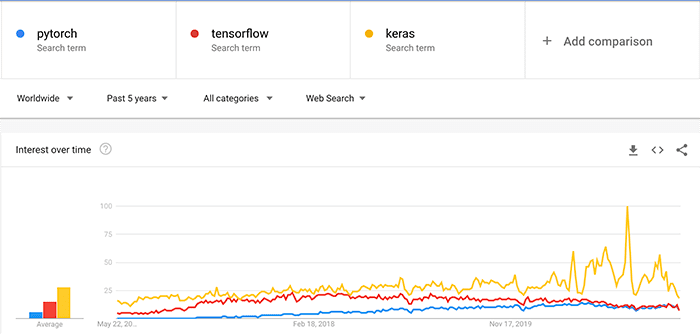

Функции высокого уровня, предоставляемые PyTorch, следующие:
 - С помощью графического процессора (GPU) он обеспечивает тензорные вычисления с сильным ускорением.
 - Он обеспечивает глубокую нейронную сеть, построенную на основе системы автоматического сравнения на основе ленты.

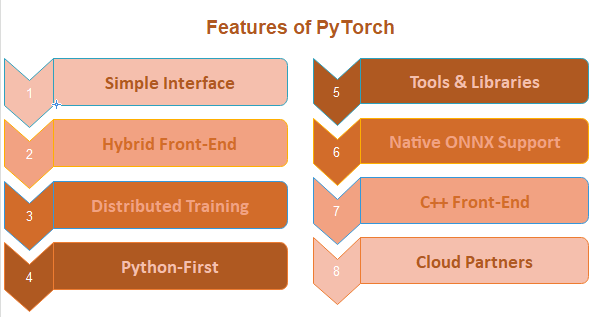

### MPI

Вплоть до 1990-х, написание параллельных приложений для различных архитектур было намного более сложным заданием чем в наши дни. Сам процесс поддерживало множество библиотек, однако для них не существовало стандартного свособа. К этому времени большинство параллельных приложений предназначалось для сред научных исследований.

Та модель, которая в основном принималась всеми разнообразными библиотеками была моделью передачи сообщений, при которой само взаимодействие между процессами происходило через обмен сообщениями и без использования совместных ресурсов. Например, процесс хозяин мог назначать некое задание своим подчинённым просто отправляя некое сообщение, которое описывало подлежащую исполнению работу. Вторым, очень простым примером здесь является некое параллельное приложение, которое выполняет некую сортировку слиянием. Все сортируемые данные локальны для всех процессов, а получаемые результаты передаются прочим процессам, которые имеют дело с данным слиянием.

Так как все библиотеки в основном применяли одну и ту же модель, хотя и с незначительными отличиями друг от друга, основные авторы имевшихся разнообразных библиотек встретились в 1992 для определения некого стандартного интерфейса обмена сообщениями и, начиная с этого момента, был рождён MPI. Этот интерфейс позволил программистам писать переносимые параллельные приложения для большинства параллельных архитектур, причём применяя те же самые функциональные возможности и модели, кторые они уже использовали.

MPI - это стандарт на программный инструментарий для обеспечения связи между ветвями параллельного приложения.

MPI расшифровывается как "Message passing interface" ("Взаимодействие через передачу сообщений"). Несколько путает дело тот факт, что этот термин уже применяется по отношению к аппаратной архитектуре ЭВМ. Программный инструментарий MPI реализован в том числе и для ЭВМ с такой архитектурой.

MPI предоставляет программисту единый механизм взаимодействия ветвей внутри параллельного приложения независимо от машинной архитектуры (однопроцессорные / многопроцессорные с общей/раздельной памятью), взаимного расположения ветвей (на одном процессоре / на разных) и API операционной системы.
( API = "applications programmers interface" = "интерфейс разработчика приложений" )

Программа, использующая MPI, легче отлаживается (сужается простор для совершения стереотипных ошибок параллельного программирования) и быстрее переносится на другие платформы (в идеале, простой перекомпиляцией).

Операции точка- точка состоят из обмена сообщениями между двумя процессами. В неком исключительном мире даже операция отправки была бы исключительно синхронизована с соответствующей операцией приёма. Очевидно что это не так и имеющаяся реализация MPI обязана предохранять отправляемые данные когда её процессы отправителя и получателя не синхронны . Обычно это происходит с применением некого буфера, который прозрачен для разработчика и полностью управляется самой библиотекой mpi4py.

Модуль Python mpi4py делает возможным взаимодействие точка- точка при помощи двух функций:
 - Comm.Send(data, process_destination): Эта функция отправляет данные в процесс назначения, идентифицируемый его порядком в имеющейся группе средства связи.

 - Comm.Recv(process_source): Эта функция получает данные от установленного процесса источника, который также идентифицируется его порядком в общей группе средств связи.
 
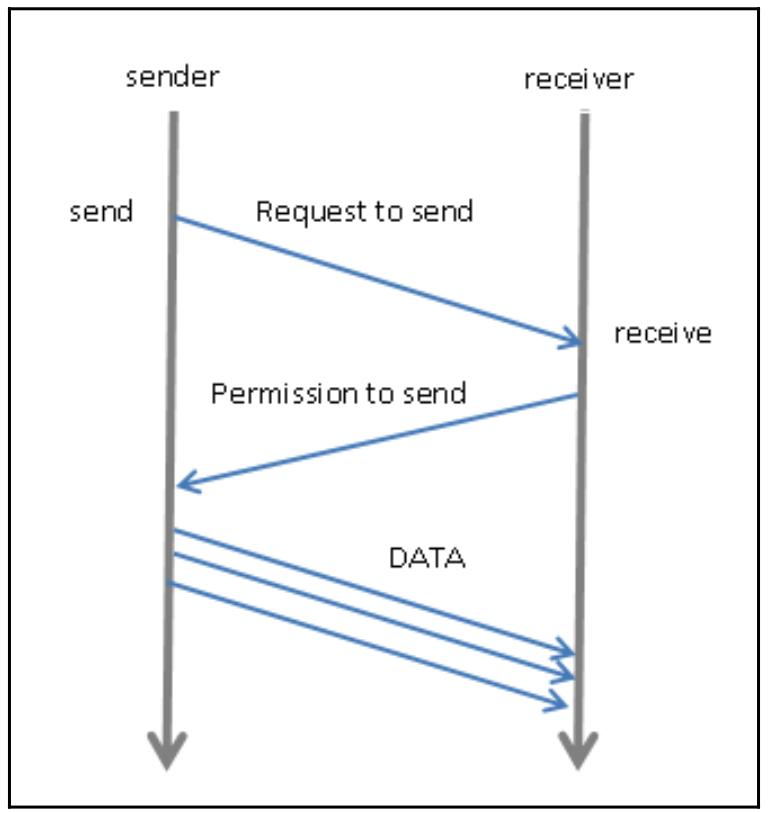

_(Рис.Схема обмена в протоколе отправки/ приёма)_

Значение параметра Comm, который является сокращением communicator (средств связи), задаёт ту группу процессов, которая может взаимодействовать через обмен сообщениями при помощи comm = MPI.COMM_WORLD.


## Text Classification Task

### Постановка задачи

Используя простую сеть, классифицировать тексты. Будет использован датасет AG NEWS доступный из **torchtext**. При помощи **MPI** выполнить задачу на нескольких процессах. На 0 процессе провести ансамблевое голосование по всем моделям с разных процессов, натренированных на разных частях датасета.

_AG News (Корпус новостей AG) - это субдатасет корпуса новостных статей AG, созданный путем объединения заголовков и полей описания статей из 4 крупнейших классов (“Мир”, “Спорт”, “Бизнес”, “Наука / техника”) свода AG. AG News содержит 30 000 обучающих и 1900 тестовых образцов для каждого класса._

### Импорт необходимого

_%% writefile -a main.py - добавление содержимого ячейки в main.py файл_

In [14]:
%%writefile main.py

import torch
import torchtext
import sklearn
import numpy as np
import mpi4py
import gc

Overwriting main.py


In [15]:
%%writefile -a main.py

from mpi4py import MPI

from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Appending to main.py


### Подготовка к использованию MPI

In [16]:
%%writefile -a main.py

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

Appending to main.py


### Создание словаря токенов

_Итератор как простая функция, которая принимает список датасетов в качестве входных данных. Затем он перебирает каждый набор данных и его текстовые примеры, получая список токенов, сгенерированных для каждого примера с помощью токенизатора. Также функция использует токен \<UNK> в качестве специального токена,которому будут сопоставлены токены, отсутствующие в словаре._

In [17]:
%%writefile -a main.py

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

Appending to main.py


### Векторизация текстовых данных
_Эта функция отвечает за векторизацию батча текстовых документов. Функция принимает в качестве входных данных один батч данных, который содержит список текстовых документов и их соответствующие целевые метки. Затем он векторизирует текстовые документы с помощью объекта CountVectorizer и возвращает их после преобразования в torch-тензоры вместе с целевыми метками._

In [18]:
%%writefile -a main.py

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = vectorizer.transform(X).todense()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y) - 1

Appending to main.py


### Определение сети

_Простая нейронная сеть из линейных слоев с использованием PyTorch, которая будет использоваться для классификации текстовых документов. Эта сеть будет принимать векторизованные данные в качестве входных данных и возвращать прогнозы. Сеть имеет 3 линейных слоя  с 128, 64 и 4 выходными блоками. Была применена активация relu ( $ReLU(x)=(x)^{+}=max(0,x)$ ) к выходу первых двух линейных слоев._

In [19]:
%%writefile -a main.py

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(len(vocab), 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4)
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

Appending to main.py


### Функция обучения модели

_Функция TrainModel принимает модель, функцию потерь, оптимизатор, загрузчик тренировочных данных, загрузчик данных проверки и количество эпох в качестве входных данных. Затем он выполняет цикл обучения несколько раз(эпох). Для каждой эпохи он перебирает обучающие данные батчами, используя загрузчик обучающих данных, который возвращает векторизованные данные и их метки для каждого пакета. Для каждой партии мы выполняем прямой сквозной анализ сети, чтобы сделать прогнозы, рассчитать потери (используя прогнозы и фактические целевые метки), рассчитать градиенты и обновить параметры сети. Функция также записывает потери для каждой партии и выводит средние потери при обучении в конце каждой эпохи. Ещё одна вспомогательная функция CalcValLossAndAccuracy, которая принимает в качестве входных данных модель, функцию потерь и загрузчик данных проверки для расчета потерь при проверке и точности._

In [20]:
%%writefile -a main.py

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, epochs):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in train_loader:
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))

Appending to main.py


### Функция для прогнозов

_Небольшая функция, которая принимает модель и загрузчик данных в качестве входных данных и возвращает прогнозы._

In [21]:
%%writefile -a main.py

def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Appending to main.py


### Применение MPI

_На 0-м процессе данные импортируются, векторизуются, делятся на части для обучения моделей и их тестирования, создаются загрузчики; далее данные отправляются на другие процессы, где модели на них обучаются, также отправляются тестовые данные; 
на 0-м процессе происходит получение массивов с предсказаниясми и далее = ансамблевое голосование: все результаты на каждом процессе сравниваются по каждому значению в тестовой подборке и выбирается предсказание, которое было чаще предложено моделями ([3,2,2] => берется 2), после проходимся по массиву с "правильными" значениями и сравниваем с предсказаниями, делим на количество значений и получаем результат ансамблевого голосования
На остальных процессах происходит обучение моделей, оценка производительности сети путем вычисления точности, отчета о классификации (точность, recall и оценка f1 для каждой целевой категории) и показателей матрицы классификации для тестовых прогнозов._

In [22]:
%%writefile -a main.py

if rank == 0:
    train_dataset, test_dataset  = torchtext.datasets.AG_NEWS()
    
    tokenizer = get_tokenizer("basic_english")
    
    vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
    vocab.set_default_index(vocab["<UNK>"])
    
    vectorizer = CountVectorizer(vocabulary=vocab.get_itos(), tokenizer=tokenizer)

    train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)
    train_dataset_1 = train_dataset[0:len(train_dataset)//4]
    train_dataset_2 = train_dataset[len(train_dataset)//4:len(train_dataset)//2]
    train_dataset_3 = train_dataset[len(train_dataset)//2:3*len(train_dataset)//4]
    train_dataset_4 = train_dataset[3*len(train_dataset)//4:len(train_dataset)]
    
    train_loader_1 = DataLoader(train_dataset_1, batch_size=256, collate_fn=vectorize_batch)
    train_loader_2 = DataLoader(train_dataset_2, batch_size=256, collate_fn=vectorize_batch)
    train_loader_3 = DataLoader(train_dataset_3, batch_size=256, collate_fn=vectorize_batch)
    train_loader_4 = DataLoader(train_dataset_4, batch_size=256, collate_fn=vectorize_batch)
    train_loader = [train_loader_1, train_loader_2, train_loader_3, train_loader_4]

    test_loader = DataLoader(test_dataset[0:len(test_dataset)//4], batch_size=256, collate_fn=vectorize_batch)
    
    Y_actual_lst = []
    Y_preds_lst = []
    for id in range(1,size):
        comm.send(vocab, dest = id)
        comm.send(vectorizer, dest = id)
        comm.send(train_loader[id], dest = id)
        comm.send(test_loader, dest = id)
        
        
        Y_actual_lst.append(comm.recv(source = id))
        Y_preds_lst.append(comm.recv(source = id))
    
    comparsion = []
    for i in range(len(Y_preds_lst[0])):
        temp = np.array([Y_preds_lst[0][i], Y_preds_lst[1][i], Y_preds_lst[2][i]])
        comparsion.append(np.argmax(np.bincount(temp)))
        
    voting_classifier = np.sum(Y_actual_lst[0] == comparsion) / len(Y_actual_lst[0])
    print("Ensemble Voting Result: ", voting_classifier)
else:
    vocab = comm.recv(source = 0)
    vectorizer = comm.recv(source = 0)
    train_loader = comm.recv(source = 0)
    test_loader = comm.recv(source = 0)
    
    target_classes = ["World", "Sports", "Business", "Sci/Tec"]
    
    epochs = 8
    learning_rate = 1e-4

    loss_fn = nn.CrossEntropyLoss()
    text_classifier = TextClassifier()
    optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

    TrainModel(text_classifier, loss_fn, optimizer, train_loader, epochs)
    CalcValLossAndAccuracy(text_classifier, loss_fn, test_loader)
    Y_actual, Y_preds = MakePredictions(text_classifier, test_loader)
    
    print("Test Accuracy on {0} process : {1}".format(rank, accuracy_score(Y_actual, Y_preds)))
    print("\nClassification Report on {} process : ".format(rank))
    print(classification_report(Y_actual, Y_preds, target_names=target_classes))
    
    comm.send(Y_actual, dest = 0)
    comm.send(Y_preds, dest = 0)

Appending to main.py


### MPI.Finalize()

In [23]:
%%writefile -a main.py

MPI.Finalize()

Appending to main.py


### Выполнение программы

In [24]:
!mpiexec -n 4 py main.py

Train Loss : 1.308
Train Loss : 0.923
Train Loss : 0.500
Train Loss : 0.305
Train Loss : 0.223
Train Loss : 0.176
Train Loss : 0.145
Train Loss : 0.121
Valid Loss : 0.384
Valid Acc  : 0.876
Test Accuracy on 3 process : 0.8763157894736842

Classification Report on 3 process : 
              precision    recall  f1-score   support

       World       0.88      0.87      0.87       487
      Sports       0.93      0.96      0.94       501
    Business       0.78      0.87      0.83       427
     Sci/Tec       0.92      0.80      0.85       485

    accuracy                           0.88      1900
   macro avg       0.88      0.88      0.87      1900
weighted avg       0.88      0.88      0.88      1900

Ensemble Voting Result:  0.8910526315789473
Train Loss : 1.304
Train Loss : 0.887
Train Loss : 0.466
Train Loss : 0.296
Train Loss : 0.222
Train Loss : 0.179
Train Loss : 0.149
Train Loss : 0.125
Valid Loss : 0.365
Valid Acc  : 0.879
Test Accuracy on 2 process : 0.8794736842105263

Class

### Выводы

- одновременное выполнение нескольких задач повышает скорость выполнения программ (является плюсом параллельного программирования)
- при написании таких программ могут возникнуть трудности в понимании, как правильно описывать алгоритмы